In [2]:
import os, time
from tqdm import tqdm
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint

from keras import backend as K

from keras.datasets import mnist

import tensorflow as tf
import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
IMG_ROWS, IMG_COLS, CHANNELS = 32, 32, 3
IMG_ROWS_EVAL, IMG_COLS_EVAL = 32, 32

***

In [32]:
dir_data      = "../img_align_celeba" #"data/img_align_celeba/"
Ntrain        = 162770
Ntest         = 19962

nm_imgs       = np.sort(os.listdir(dir_data))
print(nm_imgs.shape)
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]

def get_npdata(nm_imgs_train, img_rows = IMG_ROWS, img_cols = IMG_COLS):
    X_train = np.zeros([nm_imgs_train.shape[0], img_rows, img_cols, CHANNELS], dtype='uint8')
    for i, myid in enumerate(nm_imgs_train):
        X_train[i] = np.array(img_to_array(cv2.resize(cv2.imread(dir_data + "/" + myid)[...,::-1], dsize=(img_cols, img_rows), interpolation=cv2.INTER_AREA)))
    return(X_train)

X_train = get_npdata(nm_imgs_train, IMG_ROWS, IMG_COLS)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test, IMG_ROWS_EVAL, IMG_COLS_EVAL)
print("X_test.shape = {}".format(X_test.shape))

(202599,)
X_train.shape = (162770, 32, 32, 3)
X_test.shape = (19962, 32, 32, 3)


In [33]:
# np.save("X_train-full_162770-res_32x32.npy", X_train)
# np.save("X_test-full_19962-res_32x32.npy", X_test)

***

In [5]:
X_train = np.load("X_train-full_162770-res_32x32.npy")
X_test = np.load("X_test-full_19962-res_32x32.npy")

---

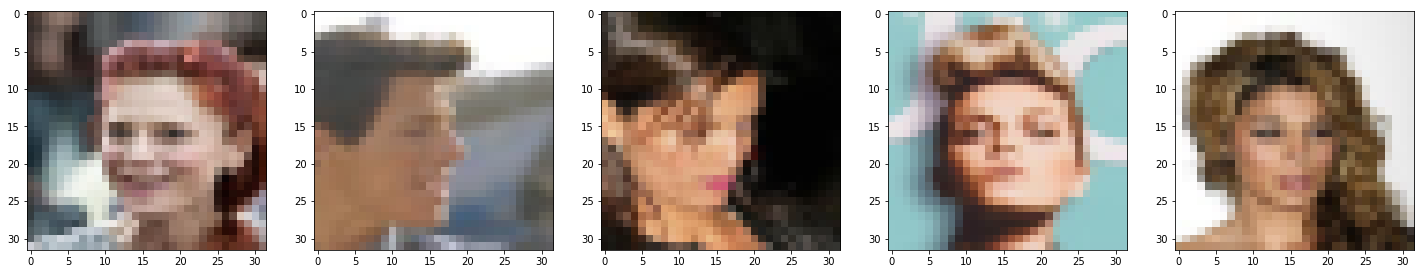

In [6]:
fig = plt.figure(figsize=(30,10))
nplot = 6
for count in range(1, nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

---

In [7]:
def img_coordinates(img_rows, img_cols):
    # [img_rows, img_cols]
    row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
    # [img_cols, img_rows]
    col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
    # [img_rows*img_cols, 2]
    x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [img_rows*img_cols,2])
    
    return x_pairs

In [8]:
def generate_data(batch_size, max_num_context, img_rows, img_cols, testing=False, index=None, num_context=None):
    
    max_num_points = img_rows*img_cols
    if num_context == None:
        if max_num_context > max_num_points:
            num_context = np.random.randint(3, max_num_points, dtype='int32')
        else:
            num_context = np.random.randint(3, max_num_context, dtype='int32')
    
    if testing:
        num_target_points = max_num_points
        set_x = X_test
    else:
        num_target_points = np.random.randint(num_context, max_num_points+1, dtype='int32')
        set_x = X_train
    
    context_x = np.zeros([batch_size, num_context, 2])
    context_y = np.zeros([batch_size, num_context, CHANNELS])
    
    target_x = np.zeros([batch_size, num_target_points, 2])
    target_y = np.zeros([batch_size, num_target_points, CHANNELS])
    
    x_pairs = img_coordinates(img_rows, img_cols)
    
    if index!=None:
        idx_1 = np.array([index])
    else:
        idx_1 = np.arange(set_x.shape[0])
        np.random.shuffle(idx_1)
        
    for i in range(batch_size):
        
        img = np.reshape(set_x[idx_1[i]], [max_num_points, CHANNELS])/255
        
        idx_2 = np.arange(max_num_points)
        np.random.shuffle(idx_2)
        
        context_x[i] = x_pairs[idx_2[:num_context]]
        context_y[i] = img[idx_2[:num_context]]
        
        if testing:
            target_x[i] = x_pairs
            target_y[i] = img
        else:
            target_x[i] = x_pairs[idx_2[:num_target_points]]
            target_y[i] = img[idx_2[:num_target_points]]


    context_xy = np.concatenate([context_x, context_y], axis=-1)
    
    return [context_xy, target_x], target_y   

In [9]:
def generate(batch_size, max_num_context, img_rows, img_cols, testing):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        inputs, targets = generate_data(batch_size, max_num_context, img_rows, img_cols, testing=testing)
        yield (inputs, targets)

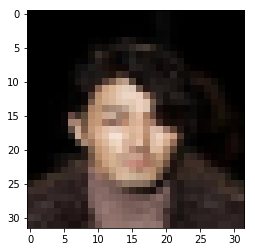

In [10]:
[context_xy, target_x], target_y = generate_data(1, IMG_ROWS_EVAL*IMG_COLS_EVAL, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True)
plt.imshow(np.array(np.round(target_y[0]*255), dtype='uint8').reshape([IMG_ROWS_EVAL, IMG_COLS_EVAL,3]))
plt.show()

---

In [13]:
def log_prob(y_true, y_pred):
    mu, sigma = tf.split(y_pred, 2, axis=-1)

    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    log_p = dist.log_prob(y_true)
    
    loss = -K.mean(log_p)
    
    return loss

___


In [14]:
"""encoder"""
input_context_xy = Input((None, 2+CHANNELS), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 2), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

encoder = Dense(128, activation='relu', name="Encoder_layer_0")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_1")(encoder)
# encoder = Dense(128, activation='relu', name="Encoder_layer_2")(encoder)
# encoder = Dense(128, activation='relu', name="Encoder_layer_3")(encoder)
# encoder = Dense(128, activation='relu', name="Encoder_layer_4")(encoder)
representation_r_i = Dense(128, activation='linear', name="Encoder_layer_2")(encoder)


"""aggregate"""
representation_r = Lambda(lambda x: K.mean(x, axis=-2), name="Mean_layer_r")(representation_r_i)


"""decoder"""
representation_r_tiled = Lambda(lambda x: K.tile(K.expand_dims(x, axis=-2), [1, K.shape(input_target_x)[-2], 1]), name="Tile_layer_r")(representation_r)

decoder_input = Concatenate(axis=-1, name="Concat_layer_r_target_x")([representation_r_tiled, input_target_x])
decoder = Dense(128, activation='relu', name="Decoder_layer_0")(decoder_input)
decoder = Dense(128, activation='relu', name="Decoder_layer_1")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_2")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_3")(decoder)
# decoder = Dense(128, activation='relu', name="Decoder_layer_4")(decoder)
# decoder = Dense(128, activation='relu', name="Decoder_layer_5")(decoder)
decoder = Dense(2*CHANNELS, activation='linear', name="Decoder_layer_4")(decoder)

mu, log_sigma = Lambda(lambda x: tf.split(x, 2, axis=-1), name="Split_layer")(decoder)
sigma = Lambda(lambda x: 0.1 + 0.9 * K.softplus(x), name="Softplus_layer_sigma")(log_sigma)


"""build model"""
output = Concatenate(axis=-1, name="Concat_layer_mu_sigma")([mu, sigma])

model = Model([input_context_xy, input_target_x], output)

model.compile(loss=log_prob, optimizer='adam')

model.summary()

model.load_weights("CNP_celebA_e3_d5_v2_b1000_rs32x32.h5")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_contxt_xy (InputLay (None, None, 5)      0                                            
__________________________________________________________________________________________________
Encoder_layer_0 (Dense)         (None, None, 128)    768         Input_layer_contxt_xy[0][0]      
__________________________________________________________________________________________________
Encoder_layer_1 (Dense)         (None, None, 128)    16512       Encoder_layer_0[0][0]            
__________________________________________________________________________________________________
Encoder_layer_2 (Dense)         (None, None, 128)    16512       Encoder_layer_1[0][0]            
_____

___


In [15]:
def process_to_plot(inputs, target_y, pred, img_rows, img_cols):
    
    target_y = np.array(np.round(target_y[0]*255), dtype='uint8').reshape([img_rows, img_cols,3])

    context_x = np.array(np.round(np.matmul(inputs[0][0, :, :2], [[img_rows, 0], [0, img_cols]])), dtype='uint16')
    context_y = np.array(np.round(inputs[0][0, :, 2:]*255), dtype='uint8')
    
    context_img = np.zeros([img_rows, img_cols, 3], dtype='uint8')
    context_img[:,:,2] = 255 # set background blue
    for i in range(context_x.shape[0]):
        context_img[context_x[i,0], context_x[i,1], :] = context_y[i]

    pred_y = np.array(np.round(np.clip(pred[0, :, :3], 0.0, 1.0)*255), dtype='uint8').reshape([img_rows, img_cols,3])

    var    = np.array(np.round(pred[0, :, 3:]*255), dtype='uint8').reshape([img_rows, img_cols,3])
    
    return target_y, pred_y, context_img, var, img_rows*img_cols, context_x.shape[0]

In [16]:
def plot_function_1(target_y, pred_y, context_img, var, max_context, num_context):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(6,6))
    ax1.imshow(target_y)
    ax1.set_title("True", fontsize = 12)
    
    ax2.imshow(pred_y)
    ax2.set_title("Predict", fontsize = 12)

    ax3.imshow(context_img)
    ax3.set_title("Context Points: Num pts=%i/%i" % (num_context, max_context), fontsize = 12)

    ax4.imshow(var)
    ax4.set_title("Variance", fontsize = 12)

    plt.show()

---

In [14]:
MAX_CONTEXT_POINTS = 5e2

repeats = 20
epochs = 5
steps_per_epoch = 2e2
steps_per_validation = 2e2
batch_size = 1000

log: r20, e5, spe2e2, spv2e2, b1000 &nbsp;&nbsp;&nbsp; CNP_celebA_e3_d5_v1_b1000_rs32x32.h5<br>
log: r20, e5, spe2e2, spv2e2, b1000 &nbsp;&nbsp;&nbsp; CNP_celebA_e3_d5_v2_b1000_rs32x32.h5<br>

Total Train: 38000 iterations of batch size 500<br>


Training model
*****************************
Repeat 1 : Sat Feb 22 00:14:45 2020
Epoch 1/5
200/200 [==============================] - 67s 336ms/step - loss: -2.1199 - val_loss: -2.4582
Epoch 2/5
200/200 [==============================] - 68s 340ms/step - loss: -2.3443 - val_loss: -2.4017
Epoch 3/5
200/200 [==============================] - 70s 350ms/step - loss: -2.3856 - val_loss: -2.4966
Epoch 4/5
200/200 [==============================] - 69s 344ms/step - loss: -2.3121 - val_loss: -2.3905
Epoch 5/5
200/200 [==============================] - 67s 336ms/step - loss: -2.3559 - val_loss: -1.9324


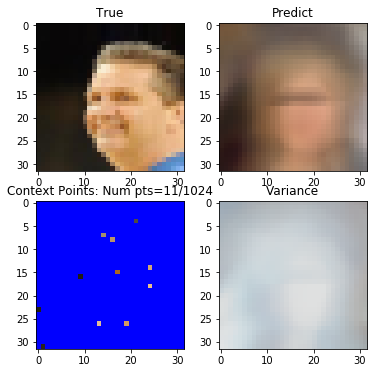

*****************************
Repeat 2 : Sat Feb 22 00:20:27 2020
Epoch 1/5
200/200 [==============================] - 68s 339ms/step - loss: -2.2848 - val_loss: -2.2019
Epoch 2/5
200/200 [==============================] - 68s 342ms/step - loss: -2.3153 - val_loss: -2.5305
Epoch 3/5
200/200 [==============================] - 67s 334ms/step - loss: -2.3445 - val_loss: -2.5140
Epoch 4/5
200/200 [==============================] - 69s 343ms/step - loss: -2.3656 - val_loss: -2.3973
Epoch 5/5
200/200 [==============================] - 67s 337ms/step - loss: -2.3186 - val_loss: -2.4604


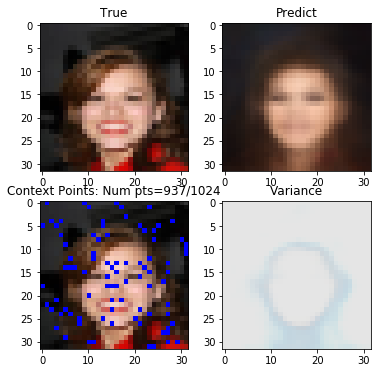

*****************************
Repeat 3 : Sat Feb 22 00:26:06 2020
Epoch 1/5
200/200 [==============================] - 70s 349ms/step - loss: -2.3313 - val_loss: -2.4750
Epoch 2/5
200/200 [==============================] - 69s 347ms/step - loss: -2.3881 - val_loss: -2.4668
Epoch 3/5
200/200 [==============================] - 69s 346ms/step - loss: -2.3718 - val_loss: -2.3963
Epoch 4/5
200/200 [==============================] - 65s 324ms/step - loss: -2.2834 - val_loss: -2.3662
Epoch 5/5
200/200 [==============================] - 66s 329ms/step - loss: -2.3507 - val_loss: -2.5013


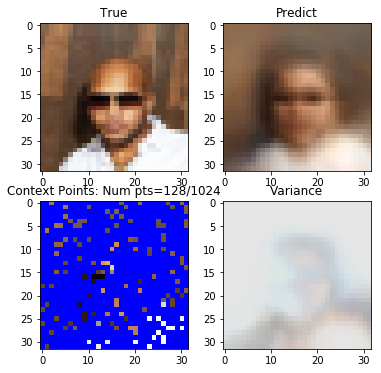

*****************************
Repeat 4 : Sat Feb 22 00:31:46 2020
Epoch 1/5
200/200 [==============================] - 66s 331ms/step - loss: -2.3473 - val_loss: -2.4114
Epoch 2/5
200/200 [==============================] - 68s 341ms/step - loss: -2.2924 - val_loss: -2.4919
Epoch 3/5
200/200 [==============================] - 68s 340ms/step - loss: -2.4189 - val_loss: -2.4685
Epoch 4/5
200/200 [==============================] - 68s 340ms/step - loss: -2.3693 - val_loss: -2.1102
Epoch 5/5
200/200 [==============================] - 68s 339ms/step - loss: -2.3578 - val_loss: -2.5049


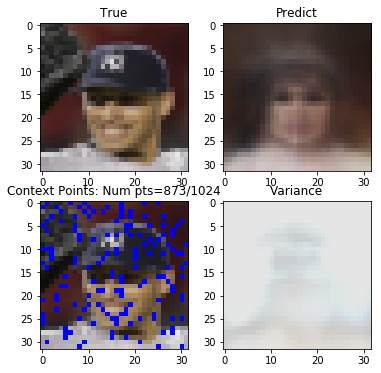

*****************************
Repeat 5 : Sat Feb 22 00:37:25 2020
Epoch 1/5
200/200 [==============================] - 68s 340ms/step - loss: -2.4150 - val_loss: -2.5379
Epoch 2/5
200/200 [==============================] - 69s 343ms/step - loss: -2.3980 - val_loss: -2.4320
Epoch 3/5
200/200 [==============================] - 65s 326ms/step - loss: -2.3722 - val_loss: -2.5623
Epoch 4/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4088 - val_loss: -1.6049
Epoch 5/5
200/200 [==============================] - 68s 340ms/step - loss: -2.4126 - val_loss: -2.5754


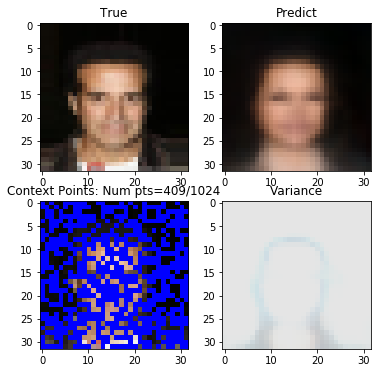

*****************************
Repeat 6 : Sat Feb 22 00:43:02 2020
Epoch 1/5
200/200 [==============================] - 68s 338ms/step - loss: -2.3818 - val_loss: -2.5021
Epoch 2/5
200/200 [==============================] - 70s 349ms/step - loss: -2.4012 - val_loss: -2.3948
Epoch 3/5
200/200 [==============================] - 66s 331ms/step - loss: -2.4014 - val_loss: -2.2285
Epoch 4/5
200/200 [==============================] - 71s 354ms/step - loss: -2.3803 - val_loss: -2.5442
Epoch 5/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4053 - val_loss: -2.2759


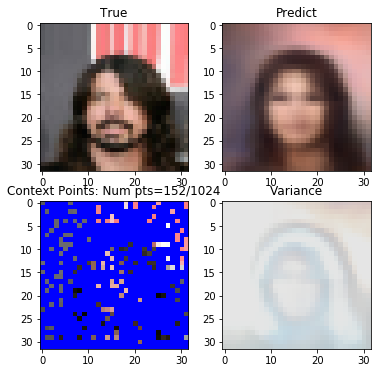

*****************************
Repeat 7 : Sat Feb 22 00:48:46 2020
Epoch 1/5
200/200 [==============================] - 68s 341ms/step - loss: -2.3913 - val_loss: -2.2661
Epoch 2/5
200/200 [==============================] - 67s 337ms/step - loss: -2.3993 - val_loss: -2.5277
Epoch 3/5
200/200 [==============================] - 67s 334ms/step - loss: -2.3659 - val_loss: -2.5332
Epoch 4/5
200/200 [==============================] - 65s 327ms/step - loss: -2.4161 - val_loss: -2.5804
Epoch 5/5
200/200 [==============================] - 68s 342ms/step - loss: -2.3932 - val_loss: -2.5958


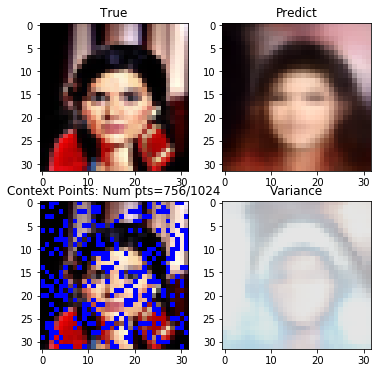

*****************************
Repeat 8 : Sat Feb 22 00:54:22 2020
Epoch 1/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4089 - val_loss: -2.2442
Epoch 2/5
200/200 [==============================] - 67s 337ms/step - loss: -2.3732 - val_loss: -2.5351
Epoch 3/5
200/200 [==============================] - 69s 344ms/step - loss: -2.4148 - val_loss: -2.5807
Epoch 4/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4085 - val_loss: -2.1802
Epoch 5/5
200/200 [==============================] - 67s 333ms/step - loss: -2.3245 - val_loss: -2.4914


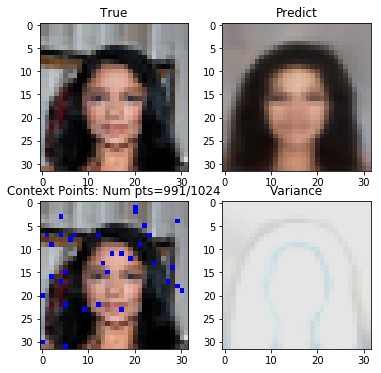

*****************************
Repeat 9 : Sat Feb 22 01:00:01 2020
Epoch 1/5
200/200 [==============================] - 66s 328ms/step - loss: -2.3597 - val_loss: -2.5654
Epoch 2/5
200/200 [==============================] - 67s 333ms/step - loss: -2.4011 - val_loss: -2.0751
Epoch 3/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4625 - val_loss: -2.5418
Epoch 4/5
200/200 [==============================] - 69s 343ms/step - loss: -2.3823 - val_loss: -1.7092
Epoch 5/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4218 - val_loss: -2.3726


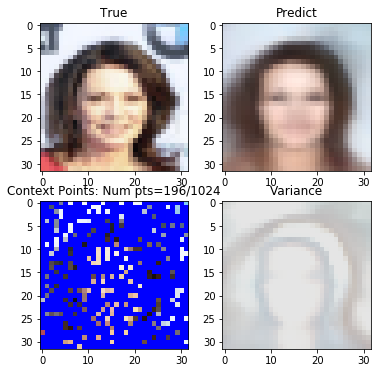

*****************************
Repeat 10 : Sat Feb 22 01:05:40 2020
Epoch 1/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4597 - val_loss: -2.4652
Epoch 2/5
200/200 [==============================] - 71s 353ms/step - loss: -2.4621 - val_loss: -2.5486
Epoch 3/5
200/200 [==============================] - 70s 352ms/step - loss: -2.3920 - val_loss: -2.5129
Epoch 4/5
200/200 [==============================] - 69s 344ms/step - loss: -2.3814 - val_loss: -2.5539
Epoch 5/5
200/200 [==============================] - 68s 339ms/step - loss: -2.4129 - val_loss: -0.9051


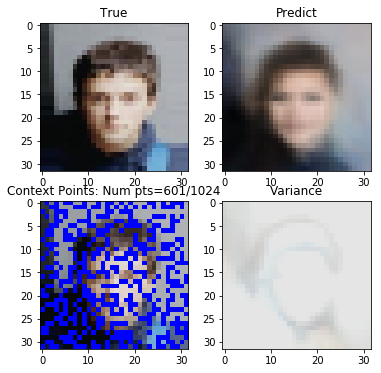

*****************************
Repeat 11 : Sat Feb 22 01:11:26 2020
Epoch 1/5
200/200 [==============================] - 69s 344ms/step - loss: -2.3961 - val_loss: -2.4107
Epoch 2/5
200/200 [==============================] - 66s 332ms/step - loss: -2.4666 - val_loss: -2.6227
Epoch 3/5
200/200 [==============================] - 68s 342ms/step - loss: -2.4527 - val_loss: -2.5143
Epoch 4/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4536 - val_loss: -2.5509
Epoch 5/5
200/200 [==============================] - 67s 335ms/step - loss: -2.3373 - val_loss: -1.7856


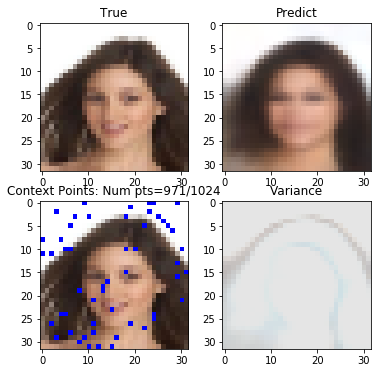

*****************************
Repeat 12 : Sat Feb 22 01:17:05 2020
Epoch 1/5
200/200 [==============================] - 69s 347ms/step - loss: -2.4799 - val_loss: -2.4081
Epoch 2/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4132 - val_loss: -2.5408
Epoch 3/5
200/200 [==============================] - 68s 342ms/step - loss: -2.4288 - val_loss: -2.5148
Epoch 4/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4534 - val_loss: -2.5330
Epoch 5/5
200/200 [==============================] - 67s 337ms/step - loss: -2.4455 - val_loss: -2.4895


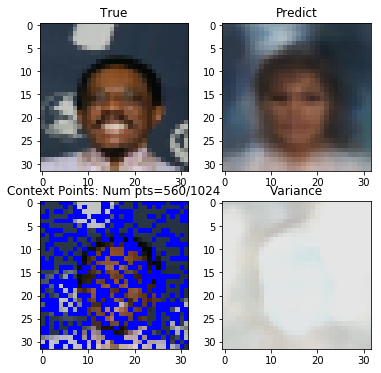

*****************************
Repeat 13 : Sat Feb 22 01:22:48 2020
Epoch 1/5
200/200 [==============================] - 70s 350ms/step - loss: -2.4529 - val_loss: -2.6109
Epoch 2/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4707 - val_loss: -2.3930
Epoch 3/5
200/200 [==============================] - 66s 330ms/step - loss: -2.4242 - val_loss: -2.5555
Epoch 4/5
200/200 [==============================] - 67s 336ms/step - loss: -2.4019 - val_loss: -2.2694
Epoch 5/5
200/200 [==============================] - 68s 341ms/step - loss: -2.4026 - val_loss: -2.1458


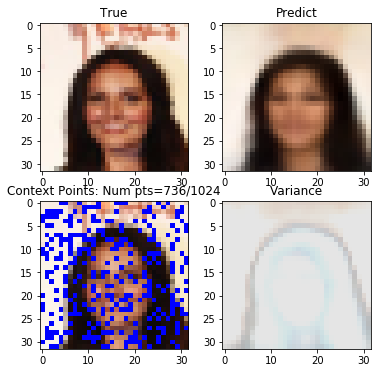

*****************************
Repeat 14 : Sat Feb 22 01:28:27 2020
Epoch 1/5
200/200 [==============================] - 70s 350ms/step - loss: -2.4905 - val_loss: -2.3591
Epoch 2/5
200/200 [==============================] - 68s 341ms/step - loss: -2.4377 - val_loss: -2.3849
Epoch 3/5
200/200 [==============================] - 69s 347ms/step - loss: -2.4434 - val_loss: -2.5881
Epoch 4/5
200/200 [==============================] - 68s 342ms/step - loss: -2.4935 - val_loss: -1.5089
Epoch 5/5
200/200 [==============================] - 66s 332ms/step - loss: -2.4072 - val_loss: -2.5572


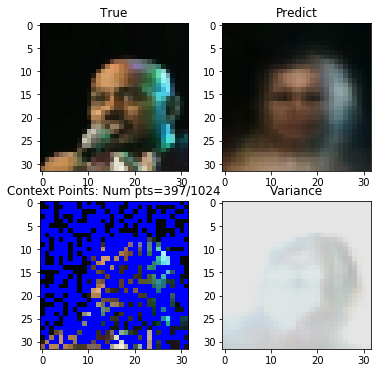

*****************************
Repeat 15 : Sat Feb 22 01:34:10 2020
Epoch 1/5
200/200 [==============================] - 67s 337ms/step - loss: -2.3974 - val_loss: -2.5736
Epoch 2/5
200/200 [==============================] - 68s 339ms/step - loss: -2.4683 - val_loss: -2.4312
Epoch 3/5
200/200 [==============================] - 67s 335ms/step - loss: -2.4704 - val_loss: -2.6003
Epoch 4/5
200/200 [==============================] - 69s 346ms/step - loss: -2.4558 - val_loss: -2.4907
Epoch 5/5
200/200 [==============================] - 68s 341ms/step - loss: -2.4722 - val_loss: -2.5464


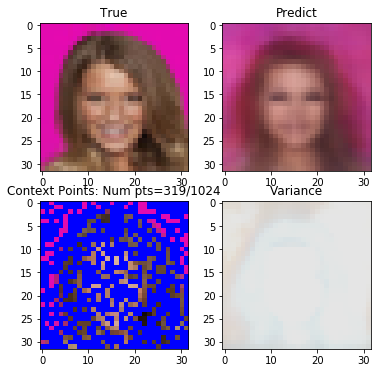

*****************************
Repeat 16 : Sat Feb 22 01:39:50 2020
Epoch 1/5
200/200 [==============================] - 69s 347ms/step - loss: -2.5136 - val_loss: -2.6592
Epoch 2/5
200/200 [==============================] - 68s 341ms/step - loss: -2.4894 - val_loss: -2.6396
Epoch 3/5
200/200 [==============================] - 67s 335ms/step - loss: -2.4445 - val_loss: -2.6638
Epoch 4/5
200/200 [==============================] - 68s 342ms/step - loss: -2.4619 - val_loss: -2.5353
Epoch 5/5
200/200 [==============================] - 67s 333ms/step - loss: -2.4360 - val_loss: -2.5924


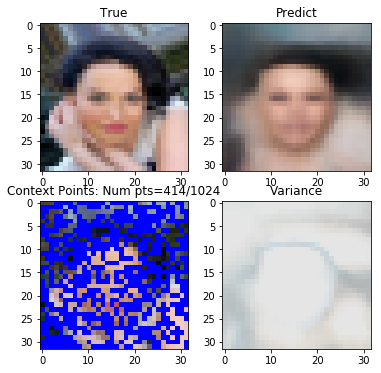

*****************************
Repeat 17 : Sat Feb 22 01:45:30 2020
Epoch 1/5
200/200 [==============================] - 69s 347ms/step - loss: -2.5040 - val_loss: -2.5274
Epoch 2/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4694 - val_loss: -2.0644
Epoch 3/5
200/200 [==============================] - 69s 346ms/step - loss: -2.4431 - val_loss: -2.5117
Epoch 4/5
200/200 [==============================] - 70s 350ms/step - loss: -2.4887 - val_loss: -2.6600
Epoch 5/5
200/200 [==============================] - 67s 337ms/step - loss: -2.4458 - val_loss: -2.5435


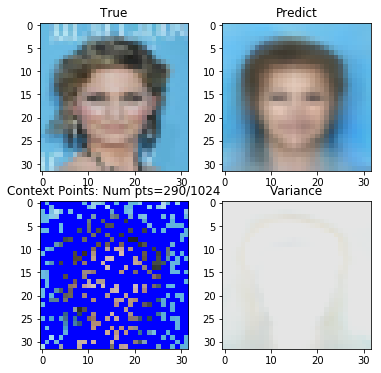

*****************************
Repeat 18 : Sat Feb 22 01:51:14 2020
Epoch 1/5
200/200 [==============================] - 67s 334ms/step - loss: -2.4422 - val_loss: -2.4258
Epoch 2/5
200/200 [==============================] - 70s 350ms/step - loss: -2.4360 - val_loss: -2.6165
Epoch 3/5
200/200 [==============================] - 67s 333ms/step - loss: -2.4972 - val_loss: -2.6115
Epoch 4/5
200/200 [==============================] - 67s 337ms/step - loss: -2.4764 - val_loss: -1.7651
Epoch 5/5
200/200 [==============================] - 67s 337ms/step - loss: -2.4878 - val_loss: -2.4297


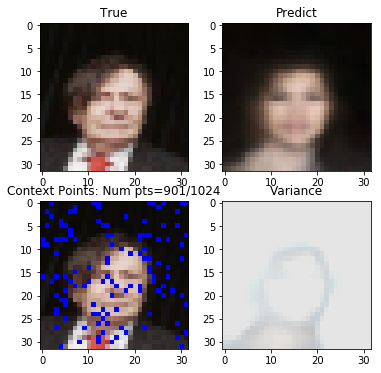

*****************************
Repeat 19 : Sat Feb 22 01:56:52 2020
Epoch 1/5
200/200 [==============================] - 68s 341ms/step - loss: -2.3302 - val_loss: -2.0591
Epoch 2/5
200/200 [==============================] - 69s 343ms/step - loss: -2.4308 - val_loss: -2.4743
Epoch 3/5
200/200 [==============================] - 70s 350ms/step - loss: -2.4827 - val_loss: -2.6302
Epoch 4/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4907 - val_loss: -2.3909
Epoch 5/5
200/200 [==============================] - 68s 340ms/step - loss: -2.4593 - val_loss: -2.1536


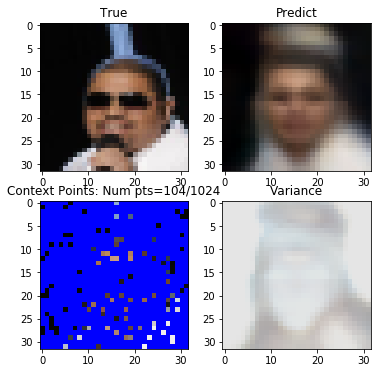

*****************************
Repeat 20 : Sat Feb 22 02:02:35 2020
Epoch 1/5
200/200 [==============================] - 68s 339ms/step - loss: -2.4918 - val_loss: -2.5494
Epoch 2/5
200/200 [==============================] - 66s 332ms/step - loss: -2.4786 - val_loss: -2.6792
Epoch 3/5
200/200 [==============================] - 66s 331ms/step - loss: -2.4998 - val_loss: -2.5898
Epoch 4/5
200/200 [==============================] - 68s 338ms/step - loss: -2.4906 - val_loss: -2.6052
Epoch 5/5
200/200 [==============================] - 66s 330ms/step - loss: -2.4605 - val_loss: -2.5025


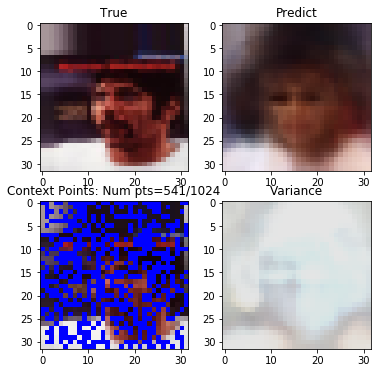

In [16]:
print('Training model')

hist = np.zeros([2, repeats*epochs], dtype='float32')

for i in range(repeats):
    print("*****************************")
    print("Repeat %i :" % (i+1), time.ctime())
    history = model.fit(generate(batch_size, MAX_CONTEXT_POINTS, IMG_ROWS, IMG_COLS, testing=False),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
#                         callbacks=[ModelCheckpoint('CNP_celebA_e4_d5_v2_b500_MIN_LOSS.h5', monitor='val_loss', save_best_only=True)],
                        validation_data=generate(batch_size, MAX_CONTEXT_POINTS, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True),
                        validation_steps=steps_per_validation)
    
    hist[0,i*epochs:(i+1)*epochs] = history.history['loss']
    hist[1,i*epochs:(i+1)*epochs] = history.history['val_loss']
    
    inputs, target_y = generate_data(1, MAX_CONTEXT_POINTS, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True)
    pred = model.predict(inputs, steps=1)

    plot_function_1(*process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL))
    
model.save_weights("CNP_celebA_e3_d5_v2_b1000_rs32x32.h5")

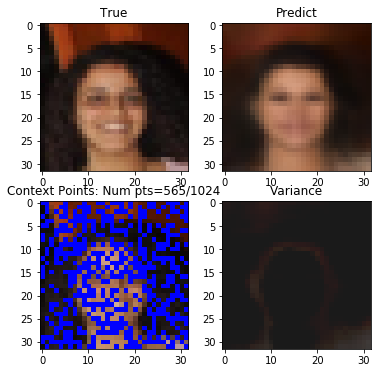

In [15]:
inputs, target_y = generate_data(1, 25000, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True)
pred = model.predict(inputs, steps=1)

plot_function_1(*process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL))

***

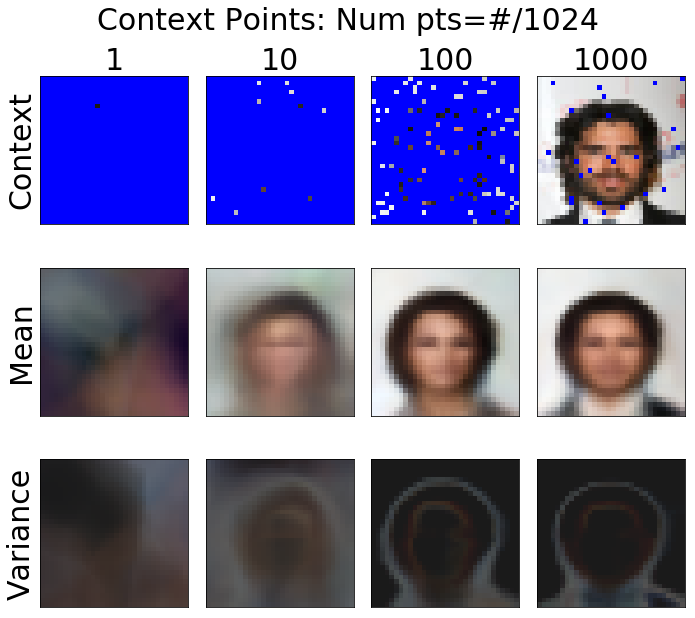

In [21]:
contexts_pts = np.array([1,10,100,1000])
labels = ["Context", "Mean", "Variance"]
font_s = 30

fig, ax = plt.subplots(3, 4, figsize=(2.44*contexts_pts.shape[0], 9))


for i in range(contexts_pts.shape[0]):
    inputs, target_y = generate_data(1, None, IMG_ROWS_EVAL, IMG_COLS_EVAL, testing=True, index=1, num_context=contexts_pts[i])
    pred = model.predict(inputs, steps=1)

    _, pred_y, context_img, var, _, _ = process_to_plot(inputs, target_y, pred, IMG_ROWS_EVAL, IMG_COLS_EVAL)
    
    ax[0, i].imshow(context_img)
    ax[0, i].set_title("%i" % (contexts_pts[i]), fontsize = font_s)
    
    ax[1, i].imshow(pred_y)
    ax[2, i].imshow(var)
    
    [ax[j, i].set_xticks([]) for j in range(len(labels))]
    [ax[j, i].set_yticks([]) for j in range(len(labels))]
    
    
[ax[j, 0].set_ylabel(labels[j], fontsize = font_s) for j in range(len(labels))]

fig.suptitle("Context Points: Num pts=#/%i" % (IMG_ROWS_EVAL*IMG_COLS_EVAL), fontsize = font_s)
fig.tight_layout()
fig.subplots_adjust(top=0.91)
fig.savefig('celebA1_1000dpi.png', dpi = 1000, bbox_inches = 'tight')
plt.show()

***

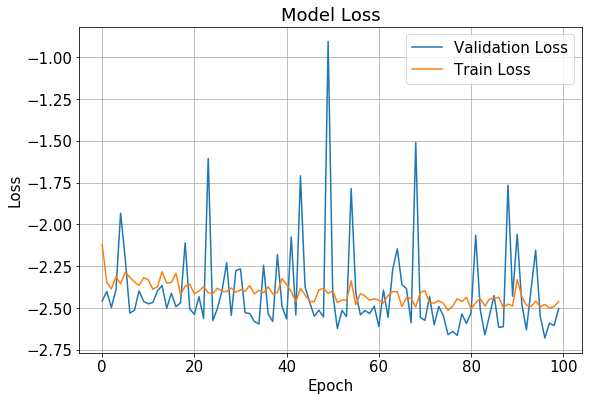

In [17]:
plt.figure(figsize=(9,6))
plt.plot(hist[1])
plt.plot(hist[0])
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Validation Loss', 'Train Loss'], loc='upper right', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()